# Vehicle Detection and Tracking

The goals / steps of this project are the following:

1. Decide what features to use
    * color based features
    * gradient based features
2. Choose and train a classifier. A linear SVM is probably a best bet for ideal combination of  speed and accuracy
3. Implement sliding window technique to search for vehicles in some test images
    * Multiscale search
    * Tiling schemes
4. Once we got a working detection pipeline, try it on a video stream, and implement tracking to detect vehicles.

## Feature extraction on a labeled training set of images

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

In [2]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, hist_range=(0, 256), orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0):    
    # Define an empty list to receive features
    img_features = []
    for image in imgs:
        img = mpimg.imread(image)
        # Apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)      
        # Compute spatial features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Compute histogram features
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Compute HOG features
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append features to list
        img_features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    
    # Return concatenated array of features
    return img_features

In [3]:
cars, notcars = [], []

cars += (glob.glob('./dataset/vehicles/GTI_Far/*.png') +
         glob.glob('./dataset/vehicles/GTI_Left/*.png') +
         glob.glob('./dataset/vehicles/GTI_MiddleClose/*.png') +
         glob.glob('./dataset/vehicles/GTI_Right/*.png') +
         glob.glob('./dataset/vehicles/KITTI_extracted/*.png'))

notcars += (glob.glob('./dataset/non-vehicles/Extras/*.png') +
            glob.glob('./dataset/non-vehicles/GTI/*.png'))

In [4]:
spatial_size = (32, 32)
hist_bins = 32
hist_range = (0, 256)

color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

In [5]:
car_features = extract_features(cars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                hist_range=hist_range, orient=orient,
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                hog_channel=hog_channel)
notcar_features = extract_features(notcars, color_space=color_space, 
                                   spatial_size=spatial_size, hist_bins=hist_bins,
                                   hist_range=hist_range, orient=orient,
                                   pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

/Users/nikhilg/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


## Train a Linear SVM classifier 

In [6]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

69.84 Seconds to train SVC...
Test Accuracy of SVC =  0.989


In [7]:
from sklearn.externals import joblib
joblib.dump(svc, 'model.pkl')

# svc = joblib.load('model.pkl') 

['model.pkl']

In [8]:
import pickle

pickle_file = 'train_test_data.p'
save_dict = {'train_dataset':X_train, 'train_labels':y_train, 'test_dataset':X_test,
             'test_labels': y_test, 'X_scaler': X_scaler}
try:
    with open(pickle_file, 'wb') as file:
        pickle.dump(save_dict,file,protocol=pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', pickle_file, ':', 'exception:', e)

## Mulit-scale windows

In general, we don't know what size our object of interest will be in the image we are searching. So it makes sense to search multiple scales. Here we are establishing minimum and maximum scale at which we expect the object to appear and then reasonable number of intermediate scales to scan as well

In [9]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [120]:
import random

start, stop, step = 90, 191, 10
xy_window = [(n, int(n * 0.65)) for n in range(start, stop, step)]
ystart = 400
overlap = 1.65
y_start_stop = [(ystart, ystart + n + 2 * step) for n in range(start, stop, step)]
xy_overlap = [((overlap * n) / ystart, (overlap * n) / ystart) for n in range(start, stop, step)]

color = []
for _ in range(start, stop, step):
    base = [0, 0, 0]
    base[random.randint(0,2)] = random.randint(150, 255)
    color.append(tuple(base))

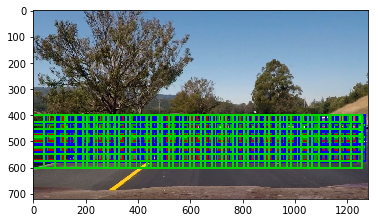

In [122]:
%matplotlib inline

image = mpimg.imread('./test_images/test6.jpg')
draw_image = np.copy(image)
image = image * 1.0 / 255

windows = []
for i in range(len(xy_window)):
    current_windows = slide_window(image, y_start_stop=y_start_stop[i], xy_window=xy_window[i], xy_overlap=xy_overlap[i])
    windows += current_windows
    draw_image = draw_boxes(draw_image, current_windows, color=color[i])

plt.imshow(draw_image)

## Use sliding-window technique and a trained classifier to search for vehicles in images

In [26]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):    
    # Define an empty list to receive features
    img_features = []
    # Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    # Compute spatial features
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    # Compute histogram features
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    # Compute HOG features
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))      
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    # Append features to list
    img_features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    
    # Return concatenated array of features
    return img_features

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

/Users/nikhilg/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


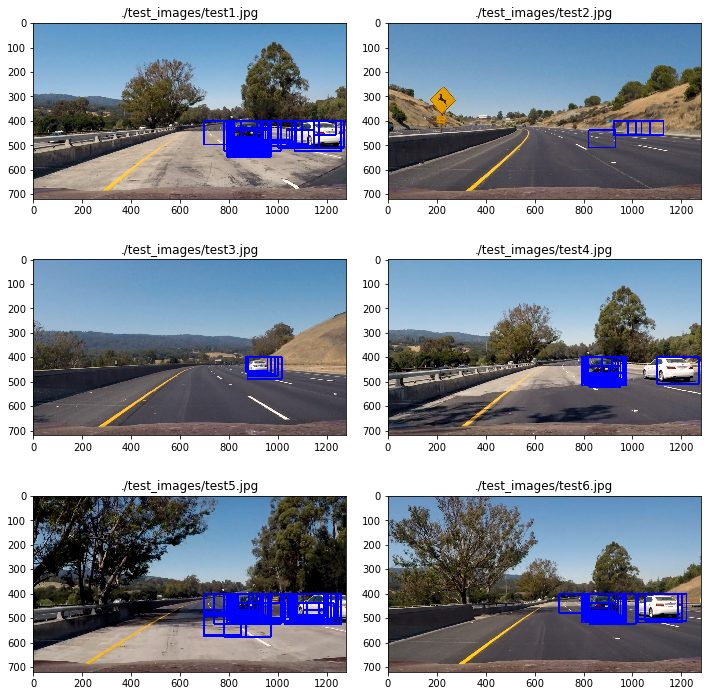

In [117]:
%matplotlib inline
f, axs = plt.subplots(3, 2, figsize=(10, 10))
axs = axs.ravel()
f.tight_layout()


start, stop, step = 90, 191, 10
xy_window = [(n, int(n * 0.65)) for n in range(start, stop, step)]
ystart = 400
overlap = 1.65
y_start_stop = [(ystart, ystart + n + 2 * step) for n in range(start, stop, step)]
xy_overlap = [((overlap * n) / ystart, (overlap * n) / ystart) for n in range(start, stop, step)]

images = glob.glob('./test_images/*.jpg')
for j, file in enumerate(images):
    image = mpimg.imread(file)
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255
    
    windows = []
    for i in range(len(xy_window)):
        # windows += slide_window(image, y_start_stop=y_start_stop[i], xy_window=xy_window[i], xy_overlap=xy_overlap[i])
        windows += slide_window(image, x_start_stop=[700, None], y_start_stop=y_start_stop[i], xy_window=xy_window[i], xy_overlap=xy_overlap[i])

    car_windows = search_windows(image, windows, svc, X_scaler, color_space='HSV', 
                             spatial_size=spatial_size, hist_bins=hist_bins, 
                             hist_range=hist_range, orient=orient, 
                             pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                             hog_channel=hog_channel)
    draw_image = draw_boxes(draw_image, car_windows)
    axs[j].imshow(draw_image)
    axs[j].set_title(file)

Results seems to be pretty good, but there is a false positive in test2.jpg.
Following section removes false positives